<a href="https://colab.research.google.com/github/olumideaeo/Machine-Learning-Collection/blob/master/Copy_of_bert_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pymagnitude git+https://github.com/huggingface/pytorch-pretrained-BERT.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.4 MB 16.2 MB/s 
     |████████████████████████████████| 596 kB 74.4 MB/s 
     |████████████████████████████████| 6.6 MB 68.5 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 


In [3]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 16.9 MB/s 
     |████████████████████████████████| 132 kB 53.1 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 8.9 MB 51.0 MB/s 
     |████████████████████████████████| 138 kB 71.5 MB/s 
     |████████████████████████████████| 127 kB 75.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [17]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
#from pymagnitude import Magnitude
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook
import os
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import random
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML
from google_drive_downloader import GoogleDriveDownloader as gdd

tqdm.pandas()

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Fine-Tuning BERT for Text Classification

While transfer learning has had a huge impact on image-based deep learning tasks, transfer learning is still a relatively new concept in NLP. The idea is that you first train a large model on a huge amount of data, and then you fine-tune the model on a smaller subset of data.

For example, we can train a large model on all of Wikipedia, then fine-tune our model on blog posts about statistics in order for our model to be able to identify the names of people in the blog posts about statistics. The model is able to leverage general understanding of language from Wikipedia to the specific task of identifying people in statistics blog posts.

The architecture of BERT is similar, and potentially the next iteration of. The architecture of the GPT-2. The GPT-2 of course uses OpenAI's Transformer, however the model can only look foward when predicting the next word in a sequence. That is to say that is is not *bidirectional*. Therefore, the GPT-2 model is more suited just as a language model for generating text than it is as a text classifier. If we want to build a solid text classifier, we should hope that we are able to consider both words before and after when looking at the text.

BERT is a **masked language model**. 15% of the input words are masked, or replaced by a special mask token. For every masked word, the model tries to use the output of the masked word to predict what the word is.

![bert overview](http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png)

BERT can be setup to perform a number of NLP tasks such as text classification.

![bert tasks](http://jalammar.github.io/images/bert-tasks.png)

- Great blog post on BERT and the source of illustrations: [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/).

In [8]:
data = pd.read_csv('/content/train.tsv', sep='\t')
data_val = pd.read_csv('/content/validation.tsv', sep='\t')

In [9]:
# convert to lowercase
data['clean_text']=data['Tweet'].str.lower()
#remove URLS
data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
#remove punctuations
data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
#remove empty lines
data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'/n',"",elem))
#remove digits
data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
#remove multiple spaces
data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
#remove single character
data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))

In [ ]:
data_val

,Tweet,Claim,Stance,Premise
0,Ordered a mask that had a cute chain attached ...,face masks,FAVOR,0
1,Who is ready for some #baseball? #BaseballisB...,stay at home orders,NONE,0
2,"'@Mystere07623203 @va_shiva @Liberty13046 130,...",face masks,FAVOR,1
3,When they ask me what I did with my life I wil...,face masks,FAVOR,0
4,Taylor not putting her album in physical store...,stay at home orders,FAVOR,0
...,...,...,...,...
595,@BrianKempGA is one of the few #Governors that...,face masks,AGAINST,1
596,'I tested positive for Covid. Got it from a fr...,face masks,FAVOR,1
597,"'If you are under retirement age, you have a *...",stay at home orders,AGAINST,1
598,'@TheLalasventure @doqholliday @realDonaldTrum...,face masks,FAVOR,0


In [10]:
import re
def clean_text(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

data['train'] = data['clean_text'].apply(clean_text)
DATA_PATH = data['train']
train_dataset = data['train']
valid_dataset = data_val['Tweet']
#data_val['val'] = data_val['clean_text'].apply(clean_txt)


## Download the training data

In [ ]:
'''DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )'''

"DATA_PATH = 'data/imdb_reviews.csv'\nif not Path(DATA_PATH).is_file():\n    gdd.download_file_from_google_drive(\n        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',\n        dest_path=DATA_PATH,\n    )"

## Preprocess the data

This part might look a little weird as BERT expects the inputs of the model to have these `[CLS]` and `[SEP]` tokens. As well, BERT expects masks and segments.

I found details on this convention [here](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_classifier.py#L251), reproduced below.

    The convention in BERT is:
    (a) For sequence pairs:
        tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    (b) For single sequences:
        tokens:   [CLS] the dog is hairy . [SEP]
        type_ids: 0     0   0   0  0     0 0

    Where "type_ids" are used to indicate whether this is the first sequence or the second sequence. The embedding vectors for `type=0` and `type=1` were learned during pre-training and are added to the wordpiece embedding vector (and position vector). This is not *strictly* necessary since the [SEP] token unambigiously separates the sequences, but it makes it easier for the model to learn the concept of sequences.

    For classification tasks, the first vector (corresponding to [CLS]) is used as as the "sentence vector". Note that this only makes sense because the entire model is fine-tuned.
    
    The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
    
Note that `type_ids` corresponds to the term `segments`. Of course, if you read the paper these oddities will make more sense.



In [11]:
class SentimentDataset(Dataset):
    def __init__(self, data_path, max_len):
        df = data

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        df['tokenized_text'] = df.train.progress_apply(self.tokenizer.tokenize)
        
        # Shorten to max length (Bert has a limit of 512); subtract two tokens for [CLS] and [SEP]
        df.loc[:, 'tokenized_text'] = df.tokenized_text.str[:max_len - 2]
        
        # Add Bert-specific beginning and end tokens
        df.loc[:, 'tokenized_text'] = df.tokenized_text.apply(
            lambda tokens: ['[CLS]'] + tokens + ['[SEP]'],
        )
        
        df['indexed_tokens'] = df.tokenized_text.progress_apply(
            self.tokenizer.convert_tokens_to_ids,
        )
        
        sequences = df.indexed_tokens.tolist()
        max_sequence_length = max(len(x) for x in sequences)
        
        self.inputs_lst, self.masks, self.segments = [], [], []
        for sequence in sequences:
            self.inputs_lst.append(sequence + (max_sequence_length - len(sequence)) * [0])
            self.masks.append(len(sequence) * [1] + (max_sequence_length - len(sequence)) * [0])
            self.segments.append(max_sequence_length * [0])
            
        self.targets = df.Premise.tolist()
        self.texts = df.train.tolist()

    def __getitem__(self, i):
        return self.inputs_lst[i], self.masks[i], self.segments[i], self.targets[i], self.texts[i]
    
    def __len__(self):
        return len(self.inputs_lst)

In [12]:
# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 128  #@param {type:"slider", min:16, max:512, step:2}

dataset = SentimentDataset(DATA_PATH, max_len)
dataset_val = SentimentDataset(valid_dataset, max_len)

100%|██████████| 3556/3556 [00:00<00:00, 103582.48it/s]


## Setup the batches

In order to avoid overloading the GPU (or CPU) memory, we have the model learn from batches of examples rather than all examples at once.

First, however, we need to split our dataset into training, validation, and testing sets.

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
#@title Splitting up the data

'''def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * valid_ratio)
    valid_length = int(len(corpus) * test_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

valid_ratio = 0.01  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.01  #@param {type:"slider", min:0.01, max:0.3, step:0.01}

# Train on only a subset of the data to reduce training time
n_samples = 5000  #@param {type:"integer"}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset,
    valid_ratio,
    test_ratio,
)
train_dataset = Subset(train_dataset, torch.randperm(len(train_dataset))[:n_samples])
len(train_dataset), len(valid_dataset), len(test_dataset)'''

'def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):\n    """Split dataset into train, validation, and test."""\n    test_length = int(len(corpus) * valid_ratio)\n    valid_length = int(len(corpus) * test_ratio)\n    train_length = len(corpus) - valid_length - test_length\n    return random_split(\n        corpus, lengths=[train_length, valid_length, test_length],\n    )\n\nvalid_ratio = 0.01  #@param {type:"slider", min:0.01, max:0.3, step:0.01}\ntest_ratio = 0.01  #@param {type:"slider", min:0.01, max:0.3, step:0.01}\n\n# Train on only a subset of the data to reduce training time\nn_samples = 5000  #@param {type:"integer"}\n\ntrain_dataset, valid_dataset, test_dataset = split_train_valid_test(\n    dataset,\n    valid_ratio,\n    test_ratio,\n)\ntrain_dataset = Subset(train_dataset, torch.randperm(len(train_dataset))[:n_samples])\nlen(train_dataset), len(valid_dataset), len(test_dataset)'

## Create the data generators

- **Batch size**: How many examples for the model to see at once. If it's too low, the model will train very slowly. If it's too high, you will run out of memory. The goal isn't necessarily to have the highest value you can get away with here. It really depends on the circumstances. For fine-tuning BERT, the recommended batch size is ony 32. Usually you will see batch sizes of 16, 32, 64, 128, or 256.

In [28]:
#@title How many examples to load on the GPU at once

def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    mask = torch.LongTensor([item[1] for item in batch])
    segment = torch.LongTensor([item[2] for item in batch])
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    
    inputs, mask, segment, target = map(
        lambda x: x.to(device),
        (inputs, mask, segment, target),
    )

    return inputs, mask, segment, target, text

batch_size = 32  #@param {type:"integer"}

train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

## Train the model

We will train the smaller model `bert-base-uncased` as the larger one has problems fitting into memory. A multi-GPU setup is likely needed for training the larger model. You can find the full list of possible models [here](https://github.com/huggingface/pytorch-pretrained-BERT#loading-google-ai-or-openai-pre-trained-weigths-or-pytorch-dump).

- **Learning rate**: How quickly the model learns. If it's too low, the model will learn very slowly. If it's too high, the model won't be able to learn at all. The goal is to have as high as value as we can get away with.

Note that learning rate should be lower than what you maybe are used to (eg. 1e-5 instead of 1e-3), as we are only fine-tuning the BERT model instead of training it from scratch. We don't want the model's parameters to drastically change as that will likely result in a decrease in model performance.

In [13]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    train_loss = total = 0
    for inputs, mask, segment, target, text in notebook.tqdm(train_loader,
                                                             desc='Training',
                                                             leave=False):
        optimizer.zero_grad()
        
        loss = model(inputs, segment, mask, target)

        train_loss += loss.item()
        total += 1
        
        loss.backward()
        optimizer.step()
        
    return train_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    with torch.no_grad():
        valid_loss = total = 0
        for inputs, mask, segment, target, text in notebook.tqdm(valid_loader,
                                                                 desc='Validating',
                                                                 leave=False):
            loss = model(inputs, segment, mask, target)

            valid_loss += loss.item()
            total += 1

        return valid_loss / total

In [21]:
#@title How big of steps the model takes while learning

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

learning_rate = 0.001  #@param {type:"number"}

param_optimizer = list(model.classifier.named_parameters()) 
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]
optimizer = BertAdam(optimizer_grouped_parameters, lr=learning_rate)

100%|██████████| 407873900/407873900 [00:34<00:00, 11926254.06B/s]
t_total value of -1 results in schedule not being applied


In [23]:
#@title Limit the number of training epochs (training is slow)

max_epochs = 3  #@param {type:"slider", min:1, max:10}

n_epochs = 0
train_losses, valid_losses = [], []
'''while True:
    train_loss = train_epoch(model, optimizer, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )
    
    # Early stopping if the current valid_loss is
    # greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1
    
    if n_epochs >= max_epochs:
        break'''

"while True:\n    train_loss = train_epoch(model, optimizer, train_loader)\n    valid_loss = validate_epoch(model, valid_loader)\n    \n    tqdm.write(\n        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',\n    )\n    \n    # Early stopping if the current valid_loss is\n    # greater than the last three valid losses\n    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):\n        print('Stopping early')\n        break\n    \n    train_losses.append(train_loss)\n    valid_losses.append(valid_loss)\n    \n    n_epochs += 1\n    \n    if n_epochs >= max_epochs:\n        break"

### Plot the training and validation losses

Typically validation loss will be higher than training loss as the model sees the training data but doesn't see the validation data. We use the validation curve to avoid overfitting to the training data: when validation loss starts to increase, stop training!

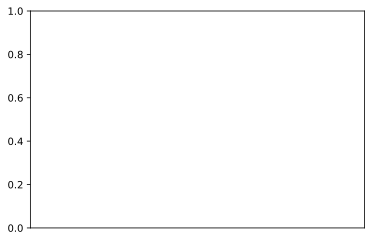

In [24]:
epoch_ticks = range(1, n_epochs + 1)
'''plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')'''
plt.xticks(epoch_ticks)
plt.show()

## Predictions

In [29]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, mask, segment, target, text in valid_loader:
        loss = model(inputs, segment, mask, target)
        logits = model(inputs, segment, mask)
        
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      2922
           1       0.12      0.26      0.17       634

    accuracy                           0.54      3556
   macro avg       0.46      0.43      0.42      3556
weighted avg       0.67      0.54      0.59      3556

